In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from q_lib import *


## Single run of Klien

In [2]:
k = np.linspace(0,1,7)
a, b, c = Q_learner(0.3, 0.95, 500000, k)


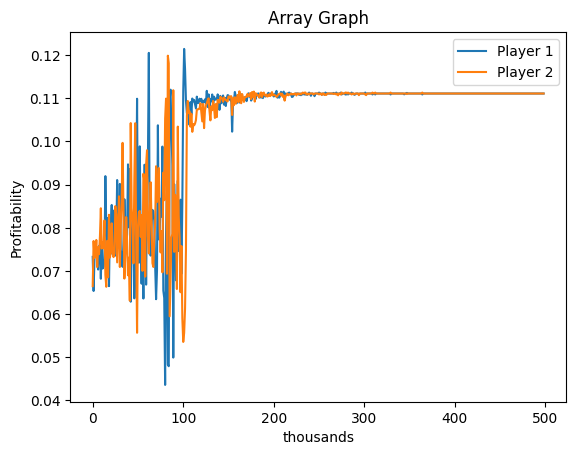

In [3]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

# joint profit maximizing

In [5]:
avg_prof, prof1, prof2, avg_prof_gain= run_sim_Q(1000, np.linspace(0,1,7))

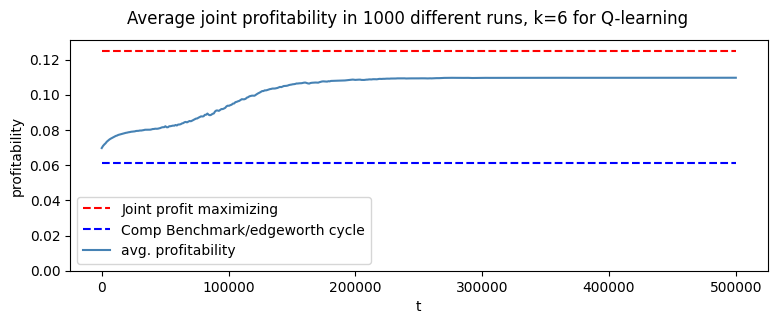

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average joint profitability in {} different runs, k={} for Q-learning".format(1000, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [7]:
avg_prof[498]

0.10964634078523099

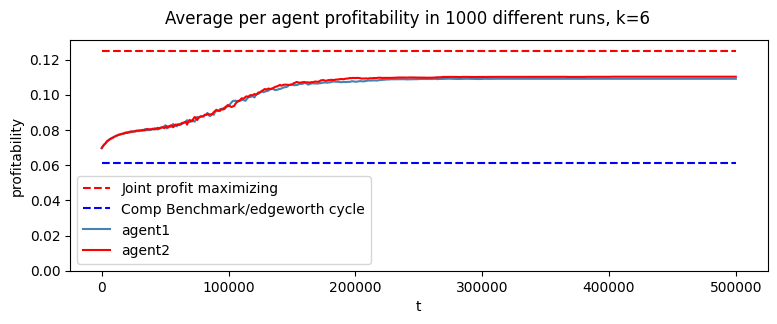

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average per agent profitability in {} different runs, k={}".format(1000, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, prof1, color="steelblue", label = "agent1")
axs.plot(xs, prof2, color="red", label = "agent2")

axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

## Price cycles

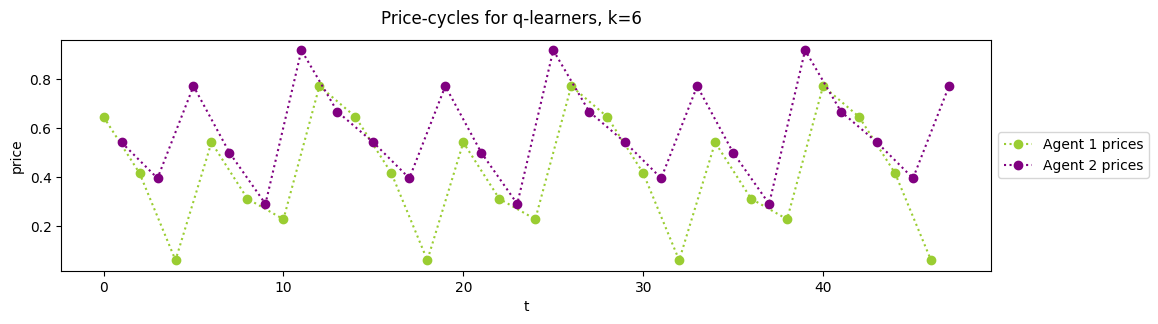

In [12]:
p, b, c = Q_learner(0.3, 0.95, 500000, np.linspace(0,1,49))
p1 = p[0,499950:500000]
p2 = p[1,499950:500000]

plt.figure(figsize=(12, 3))
p0s2d = p1[np.arange(0, p1.size, 2)][:-1]
p1s2d = p2[np.arange(1, p2.size, 2)][:-1]

plt.xlabel("t")
plt.ylabel("price")
plt.suptitle("Price-cycles for q-learners, k=6")

plt.plot(range(0, 48, 2), p0s2d , label="Agent 1 prices", marker="o", color="yellowgreen", linestyle="dotted")
plt.plot(range(1, 48, 2), p1s2d, label="Agent 2 prices", marker="o", color="purple", linestyle="dotted")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Forced deviation

In [13]:
Monk, profits, avg_2pp1,avg2pp2,avg_profitabilities= run_simFD(10,np.linspace(0,1,7))

In [14]:
MAnkA = Monk[0,::2]
MAnkaB = Monk[1,::2]

### Average Price

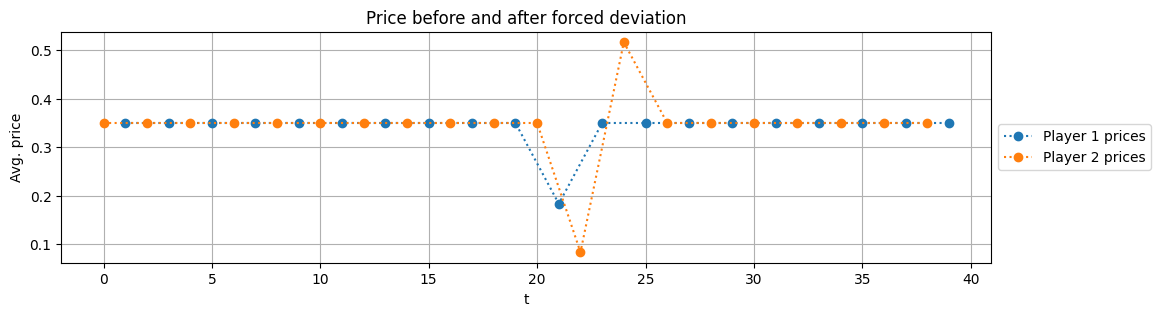

In [15]:
xvalues = range(len(MAnkA[249965:249985]))
#print(p2)
#print(new)
# Plot the array as a line graph
plt.figure(figsize=(12, 3))
plt.plot(range(1,len(xvalues)*2,2), MAnkA[249965:249985], marker="o", linestyle='dotted')
plt.plot(range(0,len(xvalues)*2,2), MAnkaB[249965:249985], marker="o", linestyle='dotted')
#plt.plot(xvalues, p2, marker="o", linestyle='dotted')

# Add labels and title
plt.grid()
plt.xlabel('t')
plt.ylabel('Avg. price')
plt.title('Price before and after forced deviation')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

### Average Two-Period Profit

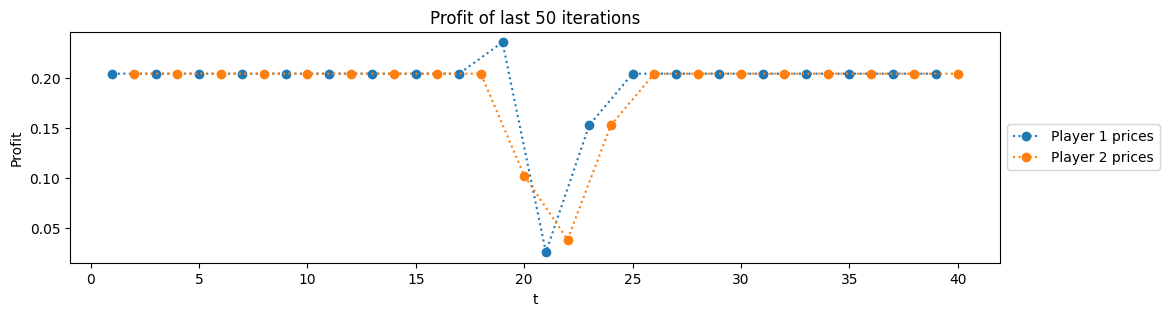

In [16]:
zoom1 = avg_profitabilities[0,249965:249985]
zoom2 = avg_profitabilities[1,249965:249985]
#print("Last 50 prices for player 1: \n", p1)
#print("Last 50 prices for player 2: \n", p2)


xvalues = range(len(zoom1))
plt.figure(figsize=(12, 3))
# Plot the array as a line graph
plt.plot(range(1,len(xvalues)*2,2), zoom1, marker="o", linestyle='dotted')
plt.plot(range(2,len(xvalues)*2+1,2), zoom2, marker="o", linestyle='dotted')

# Add labels and title
plt.xlabel('t')
plt.ylabel('Profit')
plt.title('Profit of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

In [17]:
done = True
while done:
    a, b, c, d = Klein_simulation_FD(0.3, 0.95, 500000, np.linspace(0,1,7))
    if abs(c[498] - d[498]) < 0.001 and abs(c[497] - d[497]) < 0.001 : 
        done = False

### Average market price

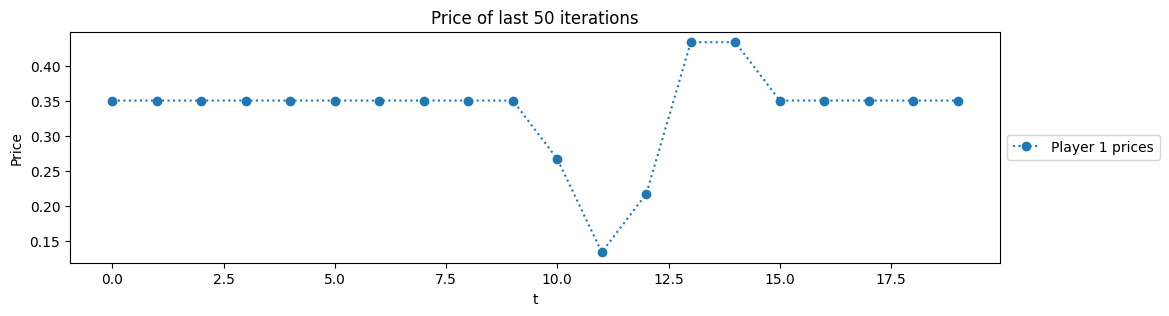

In [18]:
p1 = Monk[0,499940:499960]
p2 = Monk[1,499940:499960]


new=[]
for i in range(len(p1)):
    res=(p1[i]+p2[i])/2
    new.append(res)

xvalues = range(len(new))
plt.figure(figsize=(12, 3))

# Plot the array as a line graph
plt.plot(xvalues, new, marker="o", linestyle='dotted')


# Add labels and title
plt.xlabel('t')
plt.ylabel('Price')
plt.title('Price of last 50 iterations')
plt.legend(['Player 1 prices', 'Player 2 prices'], bbox_to_anchor=(1,0.5), loc='center left')

# Display the graph
plt.show()

## Asymmetric information

 7. maj: Nicklas implementere Anders's mening med assymetrisk information// usikkerhed i handlingsøjeblikket

In [19]:
@njit
def select_price_asym(j, t, p_table, Q_table, price_grid, epsilon):
    """
    args:
        j: player 1
        t: current period
        p_table: 2x500.000 array storing prices for player 0 and 1
        Q_table: current Q_table
        price_grid: price_grid
        epsilon: decay parameter of learning module
    returns:
        random price or maximized price
    """
    #95% Chance of observing the true state
    theta = -((1/1000000) ** (1/500000)) + 1 # theta being a decay parameter
    x = 0.05*(1 - theta) ** t 

    true_state=np.where(price_grid == p_table[j, t-1])[0][0] # current state (opponent's price)
    if x<=np.random.uniform(0,1):
        s_t_idx=true_state 
    else:
        s_t_idx=np.where(price_grid==np.random.choice(price_grid))[0][0]
    
    # Exploration
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(price_grid)
    else:
    # Exploitation
        maxedQ_idx = np.argmax(Q_table[:, s_t_idx])
        return price_grid[maxedQ_idx]


In [20]:
@njit
def Q_asym(alpha, gamma, T, price_grid):
    """
    args:
        alpha: step-size parameter
        gamma: discount factor
        T: learning duration
        price_grid: price_grid
    returns:
        p_table: 2x500.000 array, with all prices set by player 0 and 1
        avg_profs0: player 0 list of average profit for each 1000 period
        avg_profs1: player 1 list of average profit for each 1000 period
    """
    # Initializing values
    epsilon = calculate_epsilon(T)
    #i = 0
    #j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    # Setting prices for players in first 2 periods 
    p_table[0, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[1, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[0, t] = np.random.choice(price_grid) #p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        if t%2!=0:
            p_table[0,t] = p_table[0,t-1]# Det er ligemeget om det er -1 eller -2 da den sætter prisen 2 gange i træk
            p_idx = np.where(price_grid == p_table[0,t])[0][0]
            s_next = p_table[1,t-1]
            #s_next_idx = np.where(price_grid == s_next)[0][0]
            current_state_idx = np.where(price_grid == p_table[1,t-2])[0][0]
            q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, 0,1, t, alpha, gamma, p_table, q1, price_grid, s_next)

            p_table[0, t] = select_price(1, t, p_table, q1, price_grid, epsilon[t])
            p_table[1, t] = p_table[1, t-1]

            # Store profits for both firms
            profits[0, t] = profit(p_table[0,t], p_table[1,t])
            profits[1, t] = profit(p_table[1,t], p_table[0,t])
        else:
            p_table[1,t] = p_table[1,t-1]# Det er ligemeget om det er -1 eller -2 da den sætter prisen 2 gange i træk
            p_idx = np.where(price_grid == p_table[1,t])[0][0]
            s_next = p_table[0,t-1]
            #s_next_idx = np.where(price_grid == s_next)[0][0]
            current_state_idx = np.where(price_grid == p_table[0,t-2])[0][0]
            q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, 1,0, t, alpha, gamma, p_table, q1, price_grid, s_next)
            
            #questionable state for select price asym
            p_table[1, t] = select_price_asym(0, t, p_table, q1, price_grid, epsilon[t])
            p_table[0, t] = p_table[0, t-1]

            # Store profits for both firms
            profits[1, t] = profit(p_table[1,t], p_table[0,t])
            profits[0, t] = profit(p_table[0,t], p_table[1,t])


        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[0, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[1, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        #tmp = i
        #i = j
        #j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        
    return p_table, avg_profs1, avg_profs2


In [21]:
p_t, avg_prof1, avgprof2 = Q_asym(0.3, 0.95, 500000, np.linspace(0,1,7))

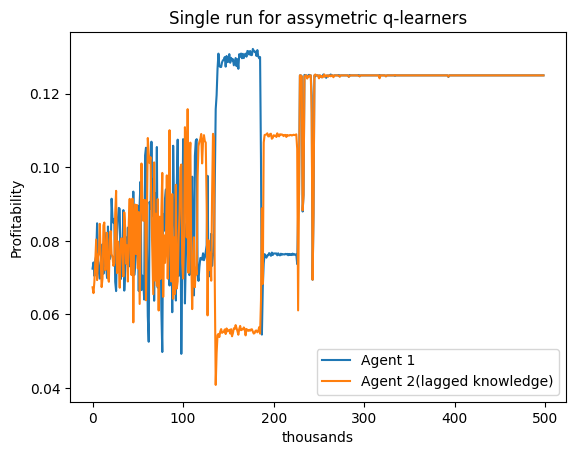

In [22]:
x_values = range(len(avg_prof1))

# Plot the array as a line graph
plt.plot(x_values, avg_prof1)
plt.plot(x_values, avgprof2)

# Add labels and title*
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Single run for assymetric q-learners')
plt.legend(['Agent 1', 'Agent 2(lagged knowledge)'])

# Display the graph
plt.show()

In [23]:

def run_sim_Q_Asym(n, k):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs=int(500000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    summed_profit1 = np.zeros(num_calcs)
    summed_profit2 = np.zeros(num_calcs)

    # simulating n runs of Klein_simulation
    for n in range(0, n):
        p_table, avg_profs1, avg_profs2 = Q_asym(0.3, 0.95, 500000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
        summed_profit1=np.sum([summed_profit1,avg_profs1],axis=0)
        summed_profit2=np.sum([summed_profit2,avg_profs2],axis=0)

    res1=np.divide(summed_profit1, n)
    res2=np.divide(summed_profit2, n)
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities,res1, res2

In [24]:
avg_avg, res1, res2 = run_sim_Q_Asym(1000, np.linspace(0, 1, 7))

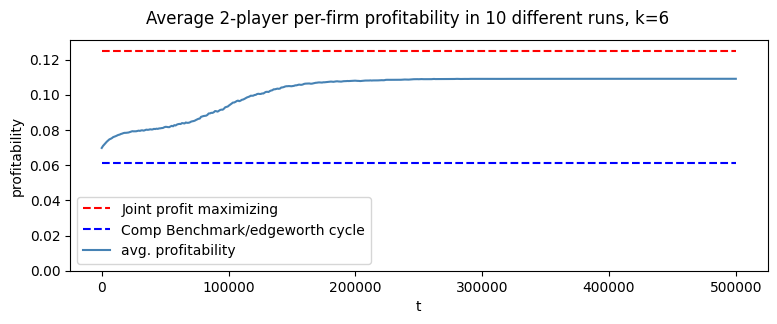

In [139]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_avg, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [25]:
avg_avg[498]

0.10947142976309769

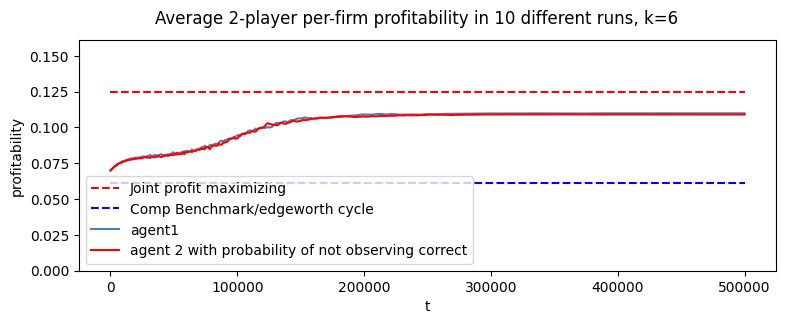

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.155+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, res1, color="steelblue", label = "agent1")
axs.plot(xs, res2, color="red", label = "agent 2 with probability of not observing correct")

axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

### Average profit gain

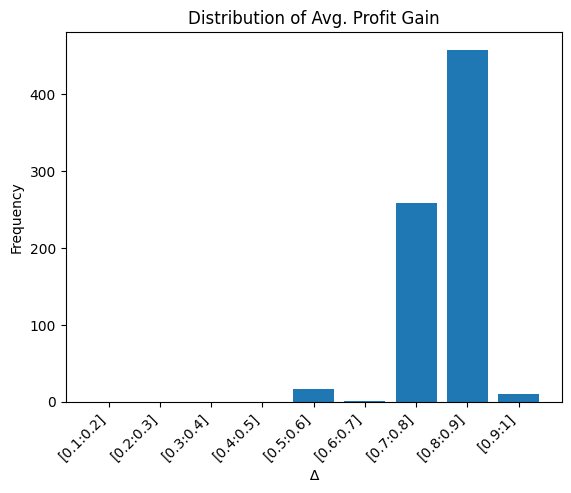

In [28]:
# Define the intervals
intervals = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0.1:0.2]','[0.2:0.3]', '[0.3:0.4]', '[0.4:0.5]', '[0.5:0.6]', '[0.6:0.7]', '[0.7:0.8]', '[0.8:0.9]', '[0.9:1]']

# Initialize an array to store counts for each interval
interval_counts = np.zeros(len(intervals), dtype=int)

# Iterate through the array and count values in each interval
for num in avg_prof_gain:
    for i, interval in enumerate(intervals):
        if interval[0] <= num < interval[1]:
            interval_counts[i] += 1

# Plot the counts for each interval
plt.bar(np.arange(len(intervals)), interval_counts, tick_label=intervals_str)
plt.xticks(rotation=45, ha='right')
plt.xlabel('∆')
plt.ylabel('Frequency')
plt.title('Distribution of Avg. Profit Gain')
plt.show()

In [ ]:
counter1=np.zeros((7, 7)) 
#counter1[1,0]=3
print(predict(counter1,1/6,np.linspace(0,1,7)))

In [ ]:
@njit
def predict(counter,last_price, price_grid):
    lp_idx = np.where(price_grid == last_price)[0][0]
    #print(counter)
    if sum(counter[:,lp_idx])==0:
        #choice_idx=np.random.choice(len(price_grid)) # assert that last price has been played
        choice_idx = random.randint(0, len(price_grid) - 1)
    else:
        ###lpc=counter[:,lp_idx]/sum(counter[:,lp_idx]) # Finds the probabilities
        #print(lpc)
        ####choice_idx=np.random.choice(np.arange(len(price_grid)), p=lpc) # Chooses an action which is random from the probability distribution
        #choice_idx=np.argmax(lpc) # Chooses the action which has the highest probability

        #Compatible with njit:
        probabilities = counter[:, lp_idx] / sum(counter[:,lp_idx])
        cumulative_probs = np.cumsum(probabilities)
        
        # Generate a random number and find its index in cumulative probabilities
        r = random.random()
        choice_idx = np.searchsorted(cumulative_probs, r)
    
    return price_grid[choice_idx]


In [ ]:
DD

In [20]:
@njit
def Q_Asym(alpha, gamma, T, price_grid):
    """
    args:
        alpha: step-size parameter
        gamma: discount factor
        T: learning duration
        price_grid: price_grid
    returns:
        p_table: 2x500.000 array, with all prices set by player 0 and 1
        avg_profs0: player 0 list of average profit for each 1000 period
        avg_profs1: player 1 list of average profit for each 1000 period
    """
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 
    counter=np.zeros((p, p))    

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    # Setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[i, t] = np.random.choice(price_grid) #p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        if t%2 == 0:
            p_table[i,t] = p_table[i,t-1]
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_next = p_table[j,t-1]
            #s_next_idx = np.where(price_grid == s_next)[0][0]
            current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]
            q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, gamma, p_table, q1, price_grid, s_next)

            p_table[i, t] = select_price(j, t, p_table, q1, price_grid, epsilon[t])
            p_table[j, t] = p_table[j, t-1]
            # Update counter
            i_idx = np.where(price_grid == p_table[i, t-1])[0][0]
            j_idx = np.where(price_grid == p_table[j, t-1])[0][0]
            counter[i_idx, j_idx] += 1

            # Store profits for both firms
            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])
        else:
            p_table[i,t] = p_table[i,t-1]
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            
            s_next = predict(counter, p_table[i,t-2], price_grid)
            #current_state_idx = np.where(price_grid == p_table[j,t-1])[0][0]

            #s_next = p_table[j,t-1]
            current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]


            q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, gamma, p_table, q1, price_grid, s_next)

            p_table[i, t] = select_price(j, t, p_table, q1, price_grid, epsilon[t])
            p_table[j, t] = p_table[j, t-1]

            # Store profits for both firms
            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])

        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        
    return p_table, avg_profs1, avg_profs2


In [ ]:
p_t, avg_prof1, avgprof2 = Q_Asym(0.3, 0.95, 500000, np.linspace(0,1,7))

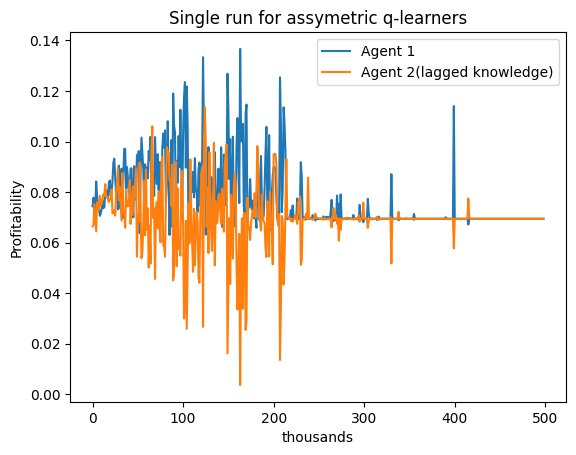

In [22]:
x_values = range(len(avg_prof1))

# Plot the array as a line graph
plt.plot(x_values, avg_prof1)
plt.plot(x_values, avgprof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Single run for assymetric q-learners')
plt.legend(['Agent 1', 'Agent 2(lagged knowledge)'])

# Display the graph
plt.show()

In [ ]:
def run_sim_Q_Asym(n, k):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs=int(500000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    summed_profit1 = np.zeros(num_calcs)
    summed_profit2 = np.zeros(num_calcs)

    # simulating n runs of Klein_simulation
    for n in range(0, n):
        p_table, avg_profs1, avg_profs2 = Q_Asym(0.3, 0.95, 500000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
        summed_profit1=np.sum([summed_profit1,avg_profs1],axis=0)
        summed_profit2=np.sum([summed_profit2,avg_profs2],axis=0)

    res1=np.divide(summed_profit1, n)
    res2=np.divide(summed_profit2, n)
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities,res1, res2

In [186]:
avg_avg, res1, res2 = run_sim_Q_Asym(1000, np.linspace(0, 1, 7))

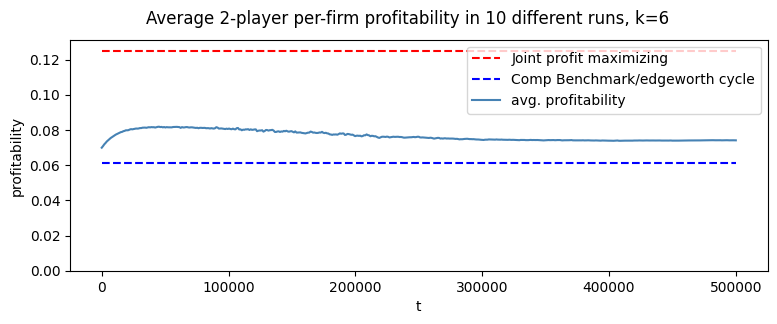

In [187]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_avg, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [ ]:
avg_avg[498]

In [188]:
avg_avg[498]

0.07407914859303637

In [ ]:
res1[498]

0.07424067122678119

In [ ]:
res1[0]

0.0697779029029028

In [45]:
@njit
def Q_Asym(alpha, gamma, T, price_grid):
    """
    args:
        alpha: step-size parameter
        gamma: discount factor
        T: learning duration
        price_grid: price_grid
    returns:
        p_table: 2x500.000 array, with all prices set by player 0 and 1
        avg_profs0: player 0 list of average profit for each 1000 period
        avg_profs1: player 1 list of average profit for each 1000 period
    """
    # Initializing values
    epsilon = calculate_epsilon(T)
    i = 0
    j = 1
    t = 0
    # Initializing Q-functions
    p = len(price_grid)
    q1 = np.zeros((p, p)) 
    q2 = np.zeros((p, p)) 
    counter=np.zeros((p, p))    

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []
    # Setting prices for players in first 2 periods 
    p_table[i, t] = np.random.choice(price_grid) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(price_grid) # firm 2 sets price
    p_table[i, t] = np.random.choice(price_grid) #p_table[i, t-1]
    t += 1 # now t = 2

    for t in range(t, T):
        if t%2 == 0:
            p_table[i,t] = p_table[i,t-1]
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_next = p_table[j,t-1]
            #s_next_idx = np.where(price_grid == s_next)[0][0]
            current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]
            q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, gamma, p_table, q1, price_grid, s_next)

            p_table[i, t] = select_price(j, t, p_table, q1, price_grid, epsilon[t])
            p_table[j, t] = p_table[j, t-1]
            # Update counter
            i_idx = np.where(price_grid == p_table[i, t-1])[0][0]
            j_idx = np.where(price_grid == p_table[j, t-1])[0][0]
            counter[i_idx, j_idx] += 1

            # Store profits for both firms
            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])
        else:
            p_table[i,t] = p_table[i,t-1]
            p_idx = np.where(price_grid == p_table[i,t])[0][0]
            s_next = p_table[j,t-1]
            #s_next_idx = np.where(price_grid == s_next)[0][0]
            current_state_idx = np.where(price_grid == p_table[j,t-2])[0][0]
       
            q1[p_idx, current_state_idx] = Q_func(p_idx, current_state_idx, i,j, t, alpha, gamma, p_table, q1, price_grid, s_next)

            if epsilon[t] >= np.random.uniform(0,1):
                p_table[i, t]= np.random.choice(price_grid)
            else:
                # Exploitation
                w= np.random.uniform(0,1)
                if w<=0.01:
                    s_t_idx = np.where(price_grid == p_table[j, t-1])[0][0] # current state (opponent's price)
                    maxedQ_idx = np.argmax(q1[:, s_t_idx])
                    p_table[i,t]= price_grid[maxedQ_idx]
                else:
                    np.random.choice(price_grid)


            #p_table[i, t] = select_price(j, t, p_table, q1, price_grid, epsilon[t])
            p_table[j, t] = p_table[j, t-1]

            # Store profits for both firms
            profits[i, t] = profit(p_table[i,t], p_table[j,t])
            profits[j, t] = profit(p_table[j,t], p_table[i,t])

        # compute avg profitability of last 1000 runs for both firms
        if t % 1000 == 0:
            profitability = np.sum(profits[i, (t-1000):t])/1000
            avg_profs1.append(profitability)
            profitability = np.sum(profits[j, (t-1000):t])/1000
            avg_profs2.append(profitability)
        
        # changing agents
        tmp = i
        i = j
        j = tmp
        tmp=q1
        q1=q2
        q2=tmp
        
    return p_table, avg_profs1, avg_profs2


In [46]:
p_t, avg_prof1, avgprof2 = Q_Asym(0.3, 0.95, 500000, np.linspace(0,1,7))

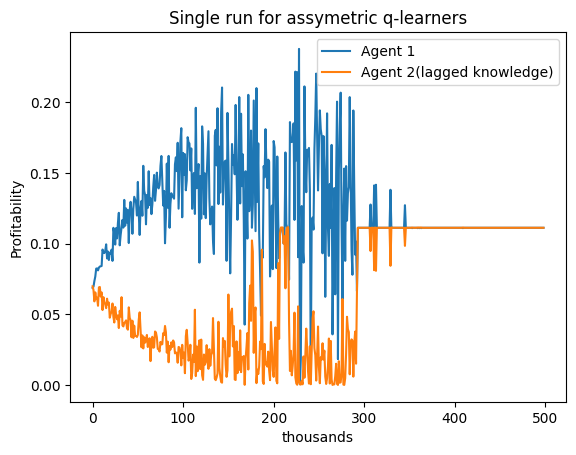

In [47]:
x_values = range(len(avg_prof1))

# Plot the array as a line graph
plt.plot(x_values, avg_prof1)
plt.plot(x_values, avgprof2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Single run for assymetric q-learners')
plt.legend(['Agent 1', 'Agent 2(lagged knowledge)'])

# Display the graph
plt.show()

In [48]:
avg_prof1[498]

0.11111111111111326

In [49]:
def run_sim_Q_Asym(n, k):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs=int(500000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    summed_profit1 = np.zeros(num_calcs)
    summed_profit2 = np.zeros(num_calcs)

    # simulating n runs of Klein_simulation
    for n in range(0, n):
        p_table, avg_profs1, avg_profs2 = Q_Asym(0.3, 0.95, 500000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
        summed_profit1=np.sum([summed_profit1,avg_profs1],axis=0)
        summed_profit2=np.sum([summed_profit2,avg_profs2],axis=0)

    res1=np.divide(summed_profit1, n)
    res2=np.divide(summed_profit2, n)
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities,res1, res2

In [53]:
avg_avg, res1, res2 = run_sim_Q_Asym(1000, np.linspace(0, 1, 7))

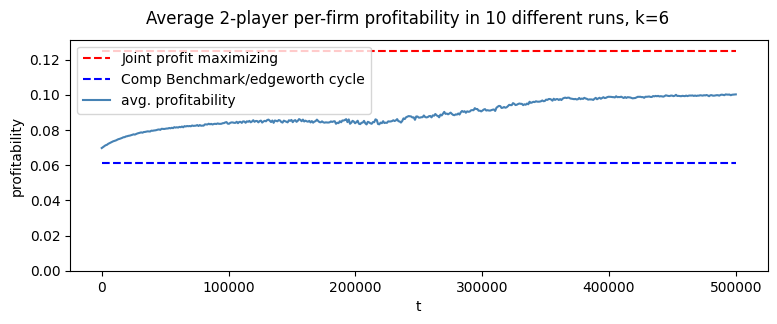

In [54]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(10, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_avg, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [56]:
avg_avg[498]

0.10018772939606437

In [114]:
theta = -((1/1000000) ** (1/500000)) + 1 # theta being a decay parameter
x = 0.05*(1 - theta) ** 500000
print(x) 

4.9999999998883006e-08
